In [110]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#%matplotlib widget

import cmocean
import glob

import os

import math
from datetime import timedelta, datetime
from operator import attrgetter

from datetime import timedelta as delta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pop_tools
from scipy.optimize import curve_fit


In [111]:
grid = pop_tools.get_grid('POP_gx1v7')[['TAREA', 'KMT', 'TLAT', 'TLONG', 'REGION_MASK']]

In [112]:
def process(da):
    
    da['ALK_excess'] = da.ALK - da.ALK_ALT_CO2
    da['DIC_excess'] = da.DIC - da.DIC_ALT_CO2
    da['pCO2_SURF_excess'] = da.pCO2SURF - da.pCO2SURF_ALT_CO2
    
    return da

Read data

In [113]:
#fpath = '/glade/scratch/mclong/OAE-Global-Efficiency/archive/smyle-fosi.North_Atlantic_basin_yearlong.alk-forcing-North_Atlantic_basin_yearlong.063-01/ocn/hist/'

# fpath = '/glade/scratch/eyankovsky/archive/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.036-5year/ocn/hist/'
# da = xr.open_mfdataset(fpath + 'smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.036-5year.pop.h.*.nc')

fpath = '/glade/scratch/eyankovsky/archive/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-5year/ocn/hist/'
da = xr.open_mfdataset(fpath + 'smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-5year.pop.h.*.nc')
print(da)

KeyboardInterrupt: 

In [ ]:
da = process(da)

In [ ]:
def excess_dic(da):
    
    dic_inv = ((da.DIC - da.DIC_ALT_CO2) * da.dz * da.TAREA).sum(['z_t', 'nlat', 'nlon']) * 1e-9
    dic_inv = dic_inv.compute()
    
    return dic_inv

In [ ]:
def cal_added_ALk(da):
    '''Total added ALK, in mol'''
    ALk_added_total = (da.ALK_FLUX * da.TAREA).sum(['time', 'nlat', 'nlon'])*1e-9*86400*31  # mol/month sum all months
    return ALk_added_total.values

In [ ]:
total_exc_alk = cal_added_ALk(da)

exc_dic = excess_dic(da)
ALk_added = (da.ALK_FLUX * da.TAREA).sum(['nlat', 'nlon'])*1e-9*86400*31  # mol/month sum all months

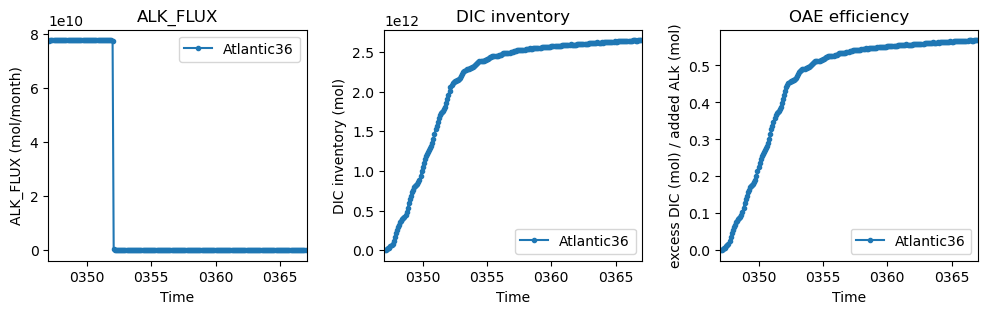

In [64]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax.plot(ALk_added.time, ALk_added.values, marker='.', label='Atlantic63')
ax.set_title('ALK_FLUX')
ax.set_ylabel('ALK_FLUX (mol/month)')
ax.set_xlabel('Time')

ax1 = fig.add_subplot(132)
ax1.plot(exc_dic.time, exc_dic, marker='.', label='Atlantic63')
ax1.set_ylabel('DIC inventory (mol)')
ax1.set_xlabel('Time')
ax1.set_title('DIC inventory')

ax2 = fig.add_subplot(133)
ax2.plot(exc_dic.time, exc_dic/total_exc_alk, marker='.', label='Atlantic63')
ax2.set_ylabel('excess DIC (mol) / added ALk (mol)')
ax2.set_xlabel('Time')
ax2.set_title('OAE efficiency')


ax.set_xlim(da.time.values[0] - timedelta(days=30), da.time.values[-1] + timedelta(days=30))
ax1.set_xlim(da.time.values[0] - timedelta(days=30), da.time.values[-1] + timedelta(days=30))
ax2.set_xlim(da.time.values[0] - timedelta(days=30), da.time.values[-1] + timedelta(days=30))

ax.legend()
ax1.legend()
ax2.legend()

plt.subplots_adjust(wspace=0.3)


# plt.savefig('/glade/work/mengyangz/GVP/figures/check_000_ALK_DIC_eff.png', 
#             dpi=200, bbox_inches='tight')

In [123]:
def plot(da, tstep):
    
        fig = plt.figure(figsize=(10,10))

        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.stock_img()
        ax.coastlines(linewidth=0.5, color='blue', resolution='110m')

        sca = ax.pcolormesh(grid.TLONG,
                      grid.TLAT,
                      da.isel(time=tstep, z_t=0).ALK_excess,
                      transform=ccrs.PlateCarree(),
                      cmap=cmocean.cm.dense,vmin=0,vmax=.5);
        cb = fig.colorbar(sca, ax=ax, shrink=0.74)
        cb.ax.set_title('meq/m^2')


        ax.set_extent([-110, 30, -50, 80], ccrs.PlateCarree())
        ax.set_xticks(np.arange(-110, 30, 10), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(-50, 80, 10), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=False)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)  

        ax.stock_img()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')

        ax.set_title('excess_ALK at surface ' + str(da.time.values[tstep])[:10], loc='left')

    #     plt.close()

    #     fig.savefig(f'/glade/work/mengyangz/GVP/figures/figs2movies/Atlantic000/{tstep:04d}.png', dpi=300, bbox_inches='tight')

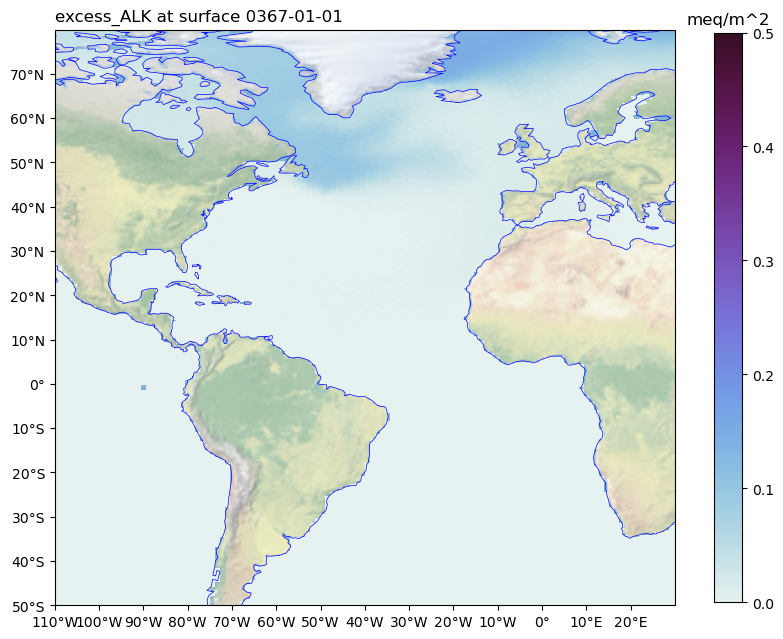

In [124]:
plot(da, -1)

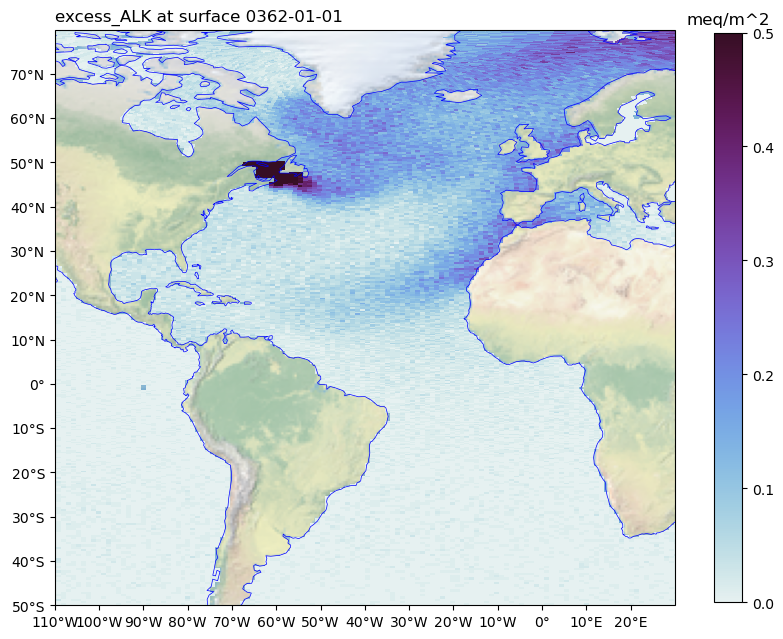

In [122]:
plot(da063_01, -1)

In [72]:
ALk_added = (da.ALK_FLUX * da.TAREA).sum(['nlat', 'nlon'])*1e-9*86400*31  # mol/month sum all months
exc_dic = excess_dic(da)


In [87]:
# fpath = '/glade/scratch/mengyangz/archive/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-1999-01/ocn/hist/'
# da063_01 = xr.open_mfdataset(fpath + 'smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.063-1999-01.pop.h.*.nc')
# da063_01 = process(da063_01)


# fpath = '/glade/scratch/mengyangz/archive/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.000-1999-01/ocn/hist/'
# da000_01 = xr.open_mfdataset(fpath + 'smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.000-1999-01.pop.h.*.nc')
# da000_01 = process(da000_01)


# fpath = '/glade/scratch/mengyangz/archive/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.016-1999-01/ocn/hist/'
# da016_01 = xr.open_mfdataset(fpath + 'smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.016-1999-01.pop.h.*.nc')
# da016_01 = process(da016_01)


fpath = '/glade/scratch/mengyangz/archive/smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.036-1999-01/ocn/hist/'
da036_01 = xr.open_mfdataset(fpath + 'smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atlantic_basin.036-1999-01.pop.h.*.nc')
da036_01 = process(da036_01)


# fpath = '/glade/scratch/mengyangz/archive/smyle-fosi.North_Pacific_basin.alk-forcing-North_Pacific_basin.105-1999-01/ocn/hist/'
# da105_01 = xr.open_mfdataset(fpath + 'smyle-fosi.North_Pacific_basin.alk-forcing-North_Pacific_basin.105-1999-01.pop.h.*.nc')
# da105_01 = process(da105_01)

# fpath = '/glade/scratch/mengyangz/archive/smyle-fosi.North_Pacific_basin.alk-forcing-North_Pacific_basin.155-1999-01/ocn/hist/'
# da155_01 = xr.open_mfdataset(fpath + 'smyle-fosi.North_Pacific_basin.alk-forcing-North_Pacific_basin.155-1999-01.pop.h.*.nc')
# da155_01 = process(da155_01)





In [ ]:
# ALk_added063 = (da063_01.ALK_FLUX * da063_01.TAREA).sum(['nlat', 'nlon'])*1e-9*86400*31  # mol/month sum all months
# exc_dic063= excess_dic(da063_01)
# total_exc_alk063 = cal_added_ALk(da063_01)

ALk_added036 = (da036_01.ALK_FLUX * da036_01.TAREA).sum(['nlat', 'nlon'])*1e-9*86400*31  # mol/month sum all months
exc_dic036= excess_dic(da036_01)
total_exc_alk036 = cal_added_ALk(da036_01)


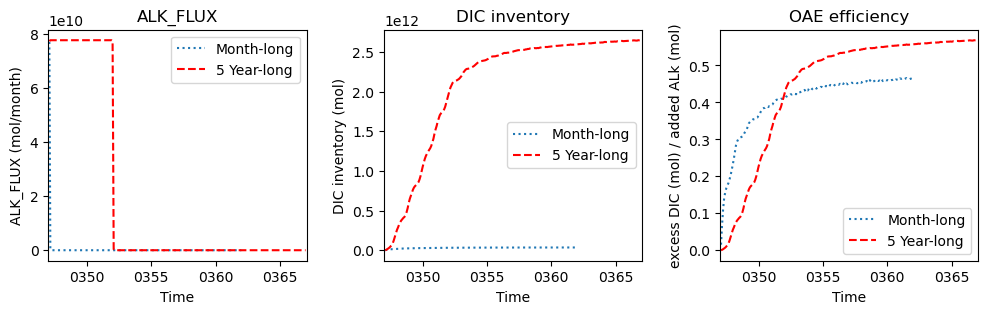

In [98]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax.plot(ALk_added036.time, ALk_added036.values, ':', label='Month-long')
ax.plot(ALk_added.time, ALk_added.values, '--', color='r', label='5 Year-long')
ax.set_title('ALK_FLUX')
ax.set_ylabel('ALK_FLUX (mol/month)')
ax.set_xlabel('Time')

ax1 = fig.add_subplot(132)
ax1.plot(exc_dic036.time, exc_dic036, ':', label='Month-long')
ax1.plot(exc_dic.time, exc_dic, '--', color='r', label='5 Year-long')

ax1.set_ylabel('DIC inventory (mol)')
ax1.set_xlabel('Time')
ax1.set_title('DIC inventory')

ax2 = fig.add_subplot(133)
ax2.plot(exc_dic036.time, exc_dic036/total_exc_alk036, ':', label='Month-long')
ax2.plot(exc_dic.time, exc_dic/total_exc_alk, '--',  color='r', label='5 Year-long')

ax2.set_ylabel('excess DIC (mol) / added ALk (mol)')
ax2.set_xlabel('Time')
ax2.set_title('OAE efficiency')


ax.set_xlim(da.time.values[0] - timedelta(days=30), da.time.values[-1] + timedelta(days=30))
ax1.set_xlim(da.time.values[0] - timedelta(days=30), da.time.values[-1] + timedelta(days=30))
ax2.set_xlim(da.time.values[0] - timedelta(days=30), da.time.values[-1] + timedelta(days=30))

ax.legend()
ax1.legend()
ax2.legend()

plt.subplots_adjust(wspace=0.3)


# plt.savefig('/glade/work/mengyangz/GVP/figures/check_000_ALK_DIC_eff.png', 
#             dpi=200, bbox_inches='tight')

In [102]:
x_data = np.array(range(15*12))
def exponential_tau(t, eta_max, ktau, gtau, htau):
    '''
    t: time
    eta_max: initial condition (this doubles as intrinsic "max" efficiency, ~0.81)
    ktau: e-folding time of gas exchange
    gtau: e-folding time of loss to the deep
    htau: e-folding time of gas exchange for the deep reservoir
    '''
    alpha = gtau/(ktau+gtau)
    tau_kg = 1.0/(1/ktau+1/gtau)
    return eta_max * (1 -  alpha*np.exp(-(1/ktau+1/gtau)*t)
                         - (1-alpha)*np.exp(-t/htau)
                         - (1-alpha)*(tau_kg/(htau - tau_kg))*(np.exp(-t/htau) - np.exp(-t/tau_kg))
                    )


def fit_params_tau(x_data, y_data, bounds=None, initial=None, pink=None, ping=None, pinh=None):
    '''Return fitted parameters'''
    # Perform the curve fitting
    if bounds is None:
        #bounds=[[ 0.849,  1.96,   0,       0],
        #        [ 0.851,  1.98,  2000,  10000]]
        bounds=[[ 0.80,  2,    0,       5],
                [ 0.88, 50 ,  2000,  10000]]
    if initial is None:
       initial = [(bounds[0][0]+bounds[1][0])/2,
                   np.clip(4,bounds[0][1],bounds[1][1]),
                   np.clip(25,bounds[0][2],bounds[1][2]),
                   np.clip(70,bounds[0][3],bounds[1][3])]
    if pink is not None:
      bounds[0][1] = pink
      bounds[1][1] = pink+0.01
      initial[1] = pink
    if ping is not None:
      bounds[0][2] = ping
      bounds[1][2] = ping+0.01
      initial[2] = ping
    if pinh is not None:
      bounds[0][3] = pinh
      bounds[1][3] = pinh+0.01
      initial[3] = pinh

    popt, pcov = curve_fit(exponential_tau, x_data, y_data, p0=initial,
                           method='trf', maxfev=10000, bounds=bounds)

    stdev = np.sqrt(np.diag(pcov))
    #print("%.2f %.1f %.1f %.1f"%tuple(stdev))
    return popt

In [2]:
def fit_to_curve_tau(s, show=False, onlydata=False, *args, **kwargs):
  x_data = np.array(range(15*12))  # time in months


### REPLACE y_data with the correct dataset ###
  y_data = (exc_dic_01/total_exc_01).values
  #y_data = (exc_dic[0:180]/total_exc_alk).values

  y_data = y_data[~np.isnan(y_data)]  # get rid of nans
  if  len(y_data)<=1: # but abort if there's no data
    return np.nan,np.nan,np.nan,np.nan
  eta_max, ktau, gtau, htau = fit_params_tau(x_data, y_data, *args, **kwargs)
  if show:
    if onlydata:
      plt.plot(x_data, y_data)
    else:
      plt.plot(x_data, y_data, c="black",ls="dashed", label=None)
      plt.plot(x_data, exponential_tau(x_data, eta_max, ktau, gtau, htau),
             label = r"%s: eta=%.2f t$_{gas}$=%.1fm t$_{loss}$=%.1fm,  t$_{slow}$=%.1fm"%(["Constrained","Free            "][s],eta_max, ktau, gtau, htau))

    plt.legend(loc='lower right')
  return eta_max, ktau, gtau, htau

In [3]:
[eta_max, ktau, gtau, htau] = fit_to_curve_tau(1,show=True)
#plt.plot(t,test1,'--r')
#plt.plot(t,test2,'--y')
#plt.plot(convolution/np.nansum(ALk_added_total),'y')
plt.ylabel('$\eta$')
plt.xlabel('Time in months')
plt.title('Month-long release and fitting')
#plt.plot([0, 190],[0.85,0.85])
plt.grid('on')
plt.xlim([0,190])
plt.ylim([.0,.9])

NameError: name 'np' is not defined

In [105]:
t = np.array(range(15*12))
alpha = gtau/(ktau+gtau)
tau_kg = 1.0/(1/ktau+1/gtau)

test1 = eta_max * (1 -  alpha*np.exp(-(1/ktau+1/gtau)*t)
                  - (1-alpha)*np.exp(-t/htau)
                  - (1-alpha)*(tau_kg/(htau - tau_kg))*(np.exp(-t/htau) - np.exp(-t/tau_kg)))



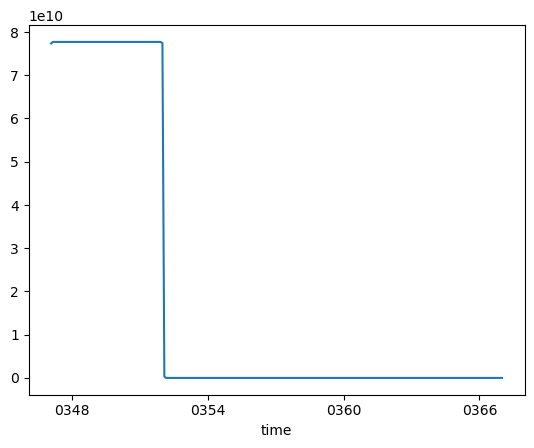

In [106]:
ALk_added_total = (da.ALK_FLUX * da.TAREA).sum(['nlat', 'nlon'])*1e-9*86400*31  # mol/month 
ALk_added_total.plot()

convolution1 = np.convolve(ALk_added_total, test1)


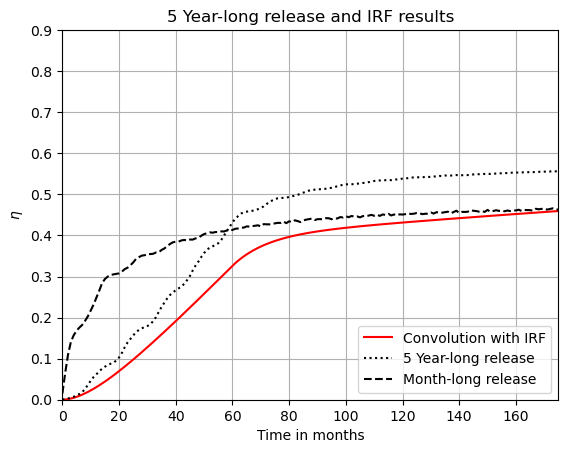

In [107]:
x_data = np.array(range(15*12))  # time in months
y_data = (exc_dic[0:180]/total_exc_alk).values
y_data = y_data[~np.isnan(y_data)]  # get rid of nans

plt.plot(convolution1/np.nansum(ALk_added_total),'r',label='Convolution with IRF')
plt.plot(x_data, y_data,'k:',label='5 Year-long release')

#plt.plot(yearlongx,yearlongy,'b:',label='Year-long release')

plt.plot(x_data, (exc_dic036/total_exc_alk036),'k--',label='Month-long release')

plt.ylabel('$\eta$')
plt.xlabel('Time in months')
plt.title('5 Year-long release and IRF results')
#plt.plot([0, 190],[0.85,0.85])
plt.grid('on')
plt.xlim([0,175])
plt.ylim([.0,.9])
plt.legend(loc='lower right')

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


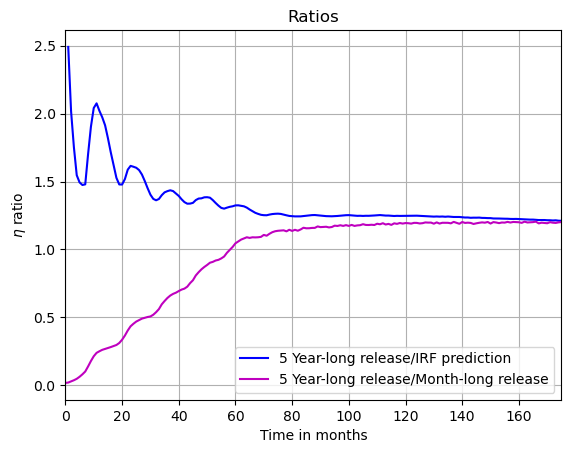

In [ ]:
x_data = np.array(range(15*12))  # time in months
y_data = (exc_dic[0:180]/total_exc_alk).values
y_data = y_data[~np.isnan(y_data)]  # get rid of nans

plt.plot(x_data, y_data/(convolution1[0:180]/np.nansum(ALk_added_total)),'b',label='5 Year-long release/IRF prediction')
plt.plot(x_data, y_data/(exc_dic036/total_exc_alk036),'m',label='5 Year-long release/Month-long release')

#plt.plot(x_data, (exc_dic063/total_exc_alk063),'k--',label='Month-long release')

plt.ylabel('$\eta$ ratio')
plt.xlabel('Time in months')
plt.title('Ratios')
#plt.plot([0, 190],[0.85,0.85])
plt.grid('on')
plt.xlim([0,175])
#plt.ylim([.0,.9])
plt.legend(loc='lower right')

In [ ]:
convolution1.shape

(419,)